In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from pandas.core.common import flatten

import torch
import os
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import  DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import random
import glob as glob
from skimage import io 

import sys
sys.path.insert(0, "/Users/alex_christlieb/Documents/Ecole Polytechnique/Exchange/DTU/Courses/Deep Learning/autotetris")

from lib.dataloader import RoofDataSet, Transforms, show_centroids
from lib.modeltraining import VarDiffloss, Resnet18_GAP, Resnet18,  train_model, test_model


#### Load Data

Using the defined classes and functions in `dataloader.py`, it is easy to load the dataset. 

In [3]:
# The path to the metadata.hdf file must be stored in a string
path = "/Users/alex_christlieb/Desktop/small_sample_out/metadata_sample.hdf"

In [3]:
raw_data = RoofDataSet(path, transform=None)

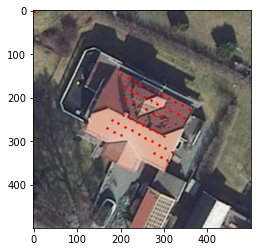

In [5]:
# Querying an index in the data loader
img, centroid = raw_data[7]

show_centroids(img, centroids=centroid, tensor=False)

#### Transform Data

The following code loads the data into a dataset. The `transform` argument in the `Transforms()` allows for a series of transformations to be called, where the input must be a list of transform functions. By default, it is configured to `['resize', 'to_tensor']`.

In [6]:
transformed_data = RoofDataSet(path, transform=Transforms(new_size=(256,256)))

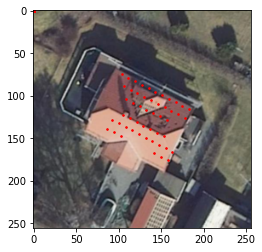

In [7]:
# Querying an index in the data loader
img, centroid = transformed_data[7]

show_centroids(img, centroids=centroid, tensor=True)

#### Split the dataset into test and validate

In [8]:
# split the dataset into validation and test sets
len_valid_set = int(0.1*len(transformed_data))
len_train_set = len(transformed_data) - len_valid_set

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))

train_dataset , valid_dataset, = torch.utils.data.random_split(transformed_data , [len_train_set, len_valid_set])

# shuffle and batch the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=8, shuffle=True, num_workers=4)

The length of Train set is 90
The length of Valid set is 10


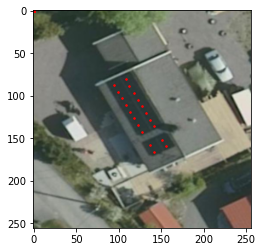

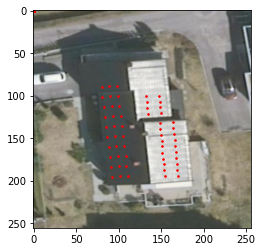

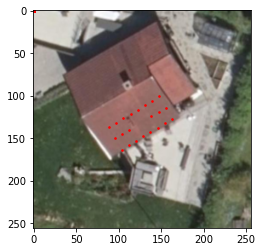

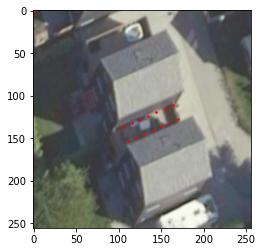

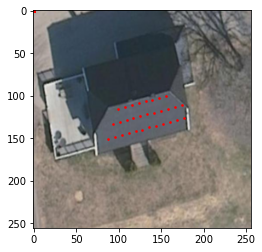

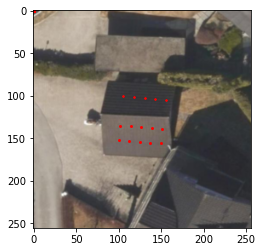

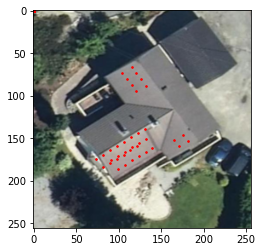

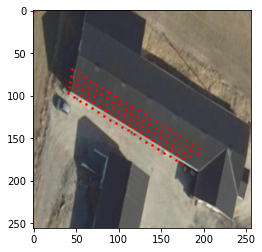

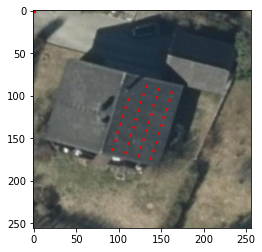

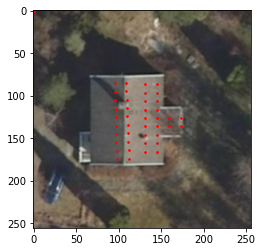

In [12]:
# plotting the validation dataset 
for house in valid_dataset:
    img, centroids = house
    show_centroids(img, centroids, tensor = True)

#### Plotting data from batches

In [13]:
# printing size of data 
images, centroids = next(iter(train_loader))

print(images.shape)
print(centroids.shape)

torch.Size([64, 3, 256, 256])
torch.Size([64, 106, 2])


### Loading Model


In [3]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from pandas.core.common import flatten

import torch
import os
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import  DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import random
import glob as glob
from skimage import io 

import sys
sys.path.insert(0, "/Users/alex_christlieb/Documents/Ecole Polytechnique/Exchange/DTU/Courses/Deep Learning/autotetris")

from lib.dataloader import RoofDataSet, Transforms, show_centroids
from lib.modeltraining import VarDiffloss, Resnet18_GAP, Resnet18_DSNT,  train_model, test_model, plot_CAM, plot_losses, plot_losses_together


In [4]:
path = "/Users/alex_christlieb/Desktop/small_sample_out/metadata_sample.hdf"
full_path = "/Users/alex_christlieb/Downloads/Dataset/data_2022-11-01/meta_data.hdf"
raw_data = RoofDataSet(full_path, transform=Transforms(transform_list=["resize", "to_tensor"]), mode = "constant")

-------------------- Initializing dataset --------------------
--> Metadata read
--> Num_panels computed
--> Samples with many panels dropped
--> Padding samples
--> Dataset ready


In [5]:
# split the dataset into training, validation and test sets
# Create testset
len_test_set = int(0.1*len(raw_data))
len_train_set = len(raw_data) - len_test_set

train_dataset , test_dataset  = torch.utils.data.random_split(raw_data, [len_train_set, len_test_set],  generator=torch.Generator().manual_seed(1))

len_valid_set = int(0.2*len(train_dataset))
len_train_set = len(train_dataset) - len_valid_set

train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [len_train_set, len_valid_set],  generator=torch.Generator().manual_seed(1))

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))
print("The length of Test set is {}".format(len_test_set))


# shuffle and batch the datasets
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
test_trained = DataLoader(train_dataset, batch_size=1, shuffle=True)

The length of Train set is 9464
The length of Valid set is 2366
The length of Test set is 1314


In [6]:
Path_res18Pauli = "/Users/alex_christlieb/Documents/Ecole Polytechnique/Exchange/DTU/Courses/Deep Learning/autotetris/trained_models/resnet_gap_5_05_12_22_a.pt"
Path = "/Users/alex_christlieb/Documents/Ecole Polytechnique/Exchange/DTU/Courses/Deep Learning/autotetris/trained_models/resnet_GAP50_cyclic_10_07_12_22_a.pt"
model = torch.load(Path, map_location=torch.device('cpu'))
model.eval()

Resnet50_GAP(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(6

In [ ]:
it = iter(test_loader)

img, centroid = next(it)

heatmaps, pred = model(img, ) 

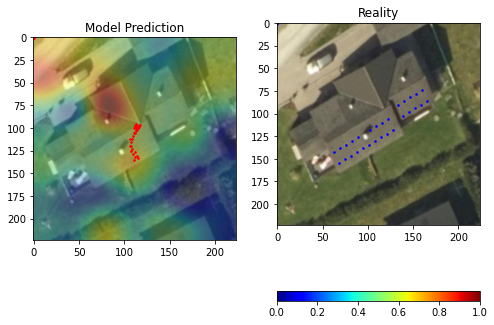

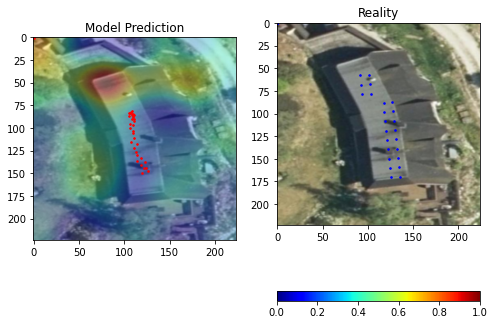

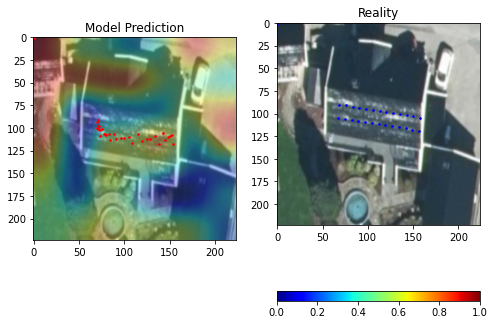

In [5]:
plot_CAM(model, test_trained, 3, raw_data.max_num_panels)

In [7]:
train_loss = np.loadtxt("train_loss_50gap.csv", delimiter="\n")
val_loss = np.loadtxt("val_loss_50gap.csv", delimiter="\n")

In [8]:
val_loss*=1.2
val_loss[0]*=1.2
val_loss[1]*=1.05

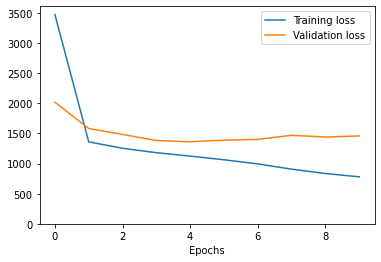

In [9]:
plot_losses_together(train_loss, val_loss)

## Testing to display the class activation map GAP

In [4]:
network = Resnet18_DSNT(num_classes=raw_data.max_num_panels)
# network = Resnet18(num_classes=raw_data.max_num_panels*2)
criterion = VarDiffloss()
# SGD diverges on our model
# optimizer = optim.SGD(network.parameters(), lr=0.0001)
optimizer = optim.Adam(network.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

loss_min = 0.001
num_epochs = 1

# Train model
model = train_model(network, criterion, optimizer, num_epochs, train_loader, valid_loader)


Valid Steps: 89/89  Loss: 12741.3044 8 
--------------------------------------------------
Epoch: 1  Train Loss: 12825.8848  Valid Loss: 12741.3044
--------------------------------------------------
Training Complete
Total Elapsed Time : 143.2333528995514 s


In [208]:
from torchsummary import summary
summary(model, input_size=(3,224,224))

torch.Size([2, 512, 1, 1])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
            

In [18]:
it_train = iter(test_loader)
image, centroid = next(it_train)

In [14]:
heatmap, prediction = model(image, heatmap = True)
image_plot = image.squeeze()
image_plot = image_plot.permute(1, 2, 0)
prediction = prediction.detach().numpy()
prediction = prediction[0]


In [17]:
heatmaps, coord = network(image, heatmap = True)
image_plot = image.squeeze()
image_plot = image_plot.permute(1, 2, 0)
coord = coord.squeeze()

AttributeError: 'bool' object has no attribute 'shape'

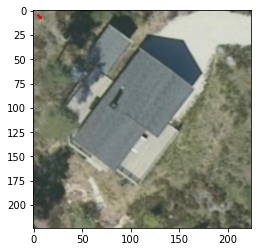

In [16]:
plt.imshow(image_plot)
plt.scatter(prediction[:, 1], prediction[:, 0], s=10, marker='.', c='r')
heatmap.shape

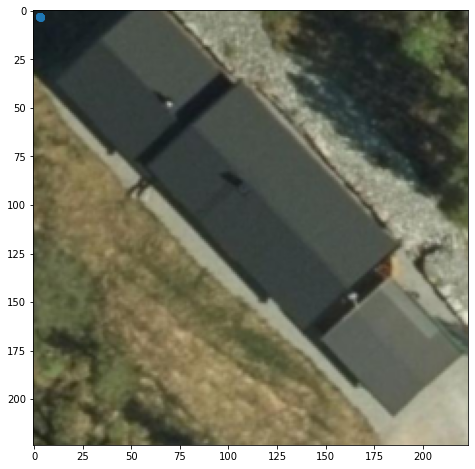

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plt.imshow(image_plot)
plt.scatter(coord[:, 1].detach(), coord[:, 0].detach())
# plt.imshow(heatmap[0, 0].detach().numpy(), alpha = 1)
# plt.show()

In [199]:
# In this code we obtain the class activation mapping and upsample it
conv_output, prediction = model(image, heatmap = True)
map = torch.mean(conv_output, dim = (0,1))

map = map.unsqueeze(dim=0)
map = map.unsqueeze(dim=1)
y = torch.nn.Upsample(scale_factor=32, mode='bicubic', recompute_scale_factor=True)
map = y(map)
map = map/torch.max(map)


In [200]:
# Preprocessing data for graphin
image_plot = image.squeeze()
image_plot = image_plot.permute(1, 2, 0)
# m2 = map.transpose(0,1)

prediction = prediction.view(-1, 37, 2)
prediction = prediction.detach().numpy()
prediction = prediction[0]

centroid_plot = centroid.squeeze()

### New testing

In [18]:
dataset = RoofDataSet(full_path, transform=Transforms(transform_list=["resize", "to_tensor", "to_heatmap"]), mode = "constant")

-------------------- Initializing dataset --------------------
--> Metadata read
--> Num_panels computed
--> Samples with many panels dropped
--> Padding samples
--> Dataset ready


In [8]:
iter = iter
img, centroid = iter(next)
b = model(img)

ValueError: expected 4D input (got 3D input)

In [ ]:
def to_heatmap(image, centroids):
    """Convert centroids into heatmap"""
    masks = []
    if type(image) != torch.Tensor:
        tensor = transforms.ToTensor()
        image = tensor(image)
    if type(centroids) == torch.Tensor:
        centroids = centroids.numpy()
        centroids = centroids[0]
    mask = torch.zeros_like(image[0])
    for coords in centroids:
        coord = [int(round(c)) for c in coords]
        mask[coord[0], coord[1]] = 1
    masks.append(mask)
    return image, torch.stack(masks)

In [11]:
from torchsummary import summary
summary(model, input_size = (3,224,224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [21]:
from torchvision import models
from torchsummary import summary

model = models.resnet50()
summary(model, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,